# NFL Win Prediction
Notebook uses an xgboost classifier model to predict whether the home team wins in an NFL game. Scores and stats come from pro-football-reference.com. The model is fit on a random 80% sample of NFL games from 2017-2020 and a 20% holdout is used for testing and validation. 

## Data Prep

In [1]:
import pandas as pd
import numpy as np

from sklearn import metrics
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import shap

from xgboost import plot_importance


In [2]:
def rename_cols(df, suff):
    for column in df.columns[2:]:
        df = df.rename(columns={column : column+suff})
    df['Tm'] = df['Tm'].str.split().str[-1]
    df['Tm'] = df['Tm'].str.replace('Team', 'WFT').replace('Redskins', 'WFT')
    return df

In [3]:
scores = pd.read_csv('data/nfl_scores_17_20.csv')
scores = scores.drop(columns=scores.columns[0])
scores['Win'] = scores['Score_Home']>scores['Score_Away']

pass_o = pd.read_csv('data/passing_17_20.csv')
rushing_o = pd.read_csv('data/rushing_17_20.csv')

pass_d = pd.read_csv('data/passing_d_17_20.csv')
rushing_d = pd.read_csv('data/rushing_d_17_20.csv')

pass_o = rename_cols(pass_o, '_pass_o')
rushing_o = rename_cols(rushing_o, '_rush_o')
offense = pass_o.merge(rushing_o, on=['Year', 'Tm'])

pass_d = rename_cols(pass_d, '_pass_d')
rushing_d = rename_cols(rushing_d, '_rush_d')
defense = pass_d.merge(rushing_d, on=['Year', 'Tm'])

In [4]:
defense.head()

,Year,Tm,G_pass_d,Cmp_pass_d,Att_pass_d,Cmp%_pass_d,Yds_pass_d,TD_pass_d,TD%_pass_d,Int_pass_d,...,ANY/A_pass_d,Sk%_pass_d,EXP_pass_d,G_rush_d,Att_rush_d,Yds_rush_d,TD_rush_d,Y/A_rush_d,Y/G_rush_d,EXP_rush_d
0,2017,Jaguars,16,289,509,56.8,2718,17,3.3,21,...,3.7,9.8,124.41,16,429,1860,9,4.3,116.3,130.30
1,2017,Vikings,16,324,555,58.4,3078,13,2.3,14,...,4.6,6.3,71.51,16,364,1337,10,3.7,83.6,73.80
2,2017,Chargers,16,329,524,62.8,3156,17,3.2,18,...,4.7,7.6,84.23,16,430,2098,11,4.9,131.1,32.37
3,2017,Broncos,16,294,491,59.9,3210,29,5.9,10,...,6.4,6.3,-23.04,16,428,1430,9,3.3,89.4,145.96
4,2017,Steelers,16,297,499,59.5,3217,20,4.0,16,...,5.2,10.1,15.99,16,385,1693,14,4.4,105.8,8.03


In [5]:
offense.head()

,Year,Tm,G_pass_o,Cmp_pass_o,Att_pass_o,Cmp%_pass_o,Yds_pass_o,TD_pass_o,TD%_pass_o,Int_pass_o,...,EXP_pass_o,G_rush_o,Att_rush_o,Yds_rush_o,TD_rush_o,Lng_rush_o,Y/A_rush_o,Y/G_rush_o,Fmb_rush_o,EXP_rush_o
0,2017,Chargers,16,366,583,62.8,4431,28,4.8,11,...,85.54,16,419,1595,10,87,3.8,99.7,17,-93.07
1,2017,Patriots,16,389,587,66.3,4418,32,5.5,8,...,197.94,16,448,1889,16,44,4.2,118.1,13,-87.22
2,2017,Steelers,16,384,590,65.1,4380,29,4.9,15,...,84.45,16,437,1667,12,29,3.8,104.2,15,-116.88
3,2017,Buccaneers,16,378,605,62.5,4366,26,4.3,14,...,41.13,16,390,1448,8,36,3.7,90.5,27,-82.91
4,2017,Saints,16,386,536,72.0,4189,23,4.3,8,...,78.77,16,444,2070,23,74,4.7,129.4,19,-71.76


In [6]:
print(len(scores))

1024


In [7]:
scores = scores.merge(offense, left_on=['Year', 'Home'], right_on=['Year', 'Tm'])
scores = scores.drop(columns='Tm')
scores = scores.merge(defense, left_on=['Year', 'Home'], right_on=['Year', 'Tm'])
scores = scores.drop(columns='Tm')

scores = scores.merge(offense, left_on=['Year', 'Away'], right_on=['Year', 'Tm'], suffixes=('', '_Away'))
scores = scores.drop(columns='Tm')
scores = scores.merge(defense, left_on=['Year', 'Away'], right_on=['Year', 'Tm'], suffixes=('', '_Away'))
scores = scores.drop(columns='Tm')

print(len(scores))

scores

1024


,Year,Week,Home,Away,Score_Home,Score_Away,Win,G_pass_o,Cmp_pass_o,Att_pass_o,...,ANY/A_pass_d_Away,Sk%_pass_d_Away,EXP_pass_d_Away,G_rush_d_Away,Att_rush_d_Away,Yds_rush_d_Away,TD_rush_d_Away,Y/A_rush_d_Away,Y/G_rush_d_Away,EXP_rush_d_Away
0,2017,1,Patriots,Chiefs,27,42,False,16,389,587,...,6.1,5.2,-27.52,16,443,1890,15,4.3,118.1,56.69
1,2017,5,Texans,Chiefs,34,42,False,16,299,525,...,6.1,5.2,-27.52,16,443,1890,15,4.3,118.1,56.69
2,2017,9,Cowboys,Chiefs,28,17,True,16,309,493,...,6.1,5.2,-27.52,16,443,1890,15,4.3,118.1,56.69
3,2017,17,Broncos,Chiefs,24,27,False,16,332,566,...,6.1,5.2,-27.52,16,443,1890,15,4.3,118.1,56.69
4,2017,3,Chargers,Chiefs,10,24,False,16,366,583,...,6.1,5.2,-27.52,16,443,1890,15,4.3,118.1,56.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,2020,10,Bears,Vikings,13,19,False,16,402,614,...,7.2,4.1,-149.87,16,472,2151,19,4.6,134.4,-41.77
1020,2020,14,Buccaneers,Vikings,26,14,True,16,410,626,...,7.2,4.1,-149.87,16,472,2151,19,4.6,134.4,-41.77
1021,2020,8,Packers,Vikings,22,28,False,16,372,526,...,7.2,4.1,-149.87,16,472,2151,19,4.6,134.4,-41.77
1022,2020,4,Texans,Vikings,23,31,False,16,383,546,...,7.2,4.1,-149.87,16,472,2151,19,4.6,134.4,-41.77


In [8]:
for index, x in scores.corrwith(scores['Win']).sort_values().items():
    print(f'{index}: {x}')

Score_Away: -0.5578110427553424
ANY/A_pass_o_Away: -0.2956812870721108
EXP_pass_o_Away: -0.2894799330182331
Rate_pass_o_Away: -0.2881630459328107
AY/A_pass_o_Away: -0.2710428731860085
TD%_pass_o_Away: -0.263544708551115
NY/A_pass_o_Away: -0.2591214183612272
Att_rush_d: -0.2511594927237381
TD_pass_o_Away: -0.2459870273713483
TD_rush_o_Away: -0.237895060533158
Rate_pass_d: -0.2309610611535205
ANY/A_pass_d: -0.2253324740062734
Cmp%_pass_o_Away: -0.22016753111409126
AY/A_pass_d: -0.21955368904344913
Y/A_pass_o_Away: -0.21005521895732238
Yds.1_pass_d_Away: -0.20995691568498612
Yds.1_pass_o: -0.20717789828876199
Sk_pass_o: -0.20423543000095631
PD_pass_d_Away: -0.20375493871082095
Int_pass_o: -0.20036529402206318
NY/A_pass_d: -0.18833816523472746
Att_rush_o_Away: -0.1877155908632669
Int%_pass_o: -0.18553156413051825
Yds_rush_d: -0.18084793253701895
Y/G_rush_d: -0.18083694710328319
Sk_pass_d_Away: -0.17777645605196257
TD_rush_d: -0.1771945496823799
TD%_pass_d: -0.17494408155404778
Cmp%_pass_d:

## Modeling

### Split Data and Train a Bunch of Different Classifier Algorithms

In [9]:
np.random.seed(69)

full = scores.copy()

full['Rand_Int'] = np.random.randint(10,size=len(full))
full = full.fillna(0)

features = list(full.columns)
features.remove('Away')
features.remove('Home')
features.remove('Score_Home')
features.remove('Score_Away')
features.remove('Win')
features.remove('Rand_Int')

full_test = full[full['Rand_Int']>=8].reset_index(drop=True)
full_train = full[full['Rand_Int']<8].reset_index(drop=True)

ytrain = full_train['Win']
xtrain = full_train.drop(columns=['Win'])

ytest = full_test['Win']
xtest = full_test.drop(columns=['Win'])


RF = RandomForestClassifier(random_state = 0, max_depth=4, n_jobs=4, n_estimators=10)
SVM = SVC(random_state=0, max_iter=20, probability=True)
DT = DecisionTreeClassifier(random_state=0, max_depth=6)
MLP = MLPClassifier(random_state=0, alpha=.001, max_iter = 10, early_stopping=True)
XGB = XGBClassifier(random_state = 0, max_depth=4, n_jobs=4, n_estimators=10)
LG = LogisticRegression(random_state=0, n_jobs=4, max_iter=10, solver='lbfgs')

models = [RF, SVM, DT, MLP, XGB, LG]

for x in models:
    x.fit(xtrain[features], ytrain)

Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
Stochastic Optimizer: Maximum iteration

[01:43:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Plot ROC Curves for Each Model
I tested a simple ensembling method that averages the probabilities from the RF and XGB algorithms. This has worked well in some other classification problems I've worked on but XGB on its own appears far and away the best.

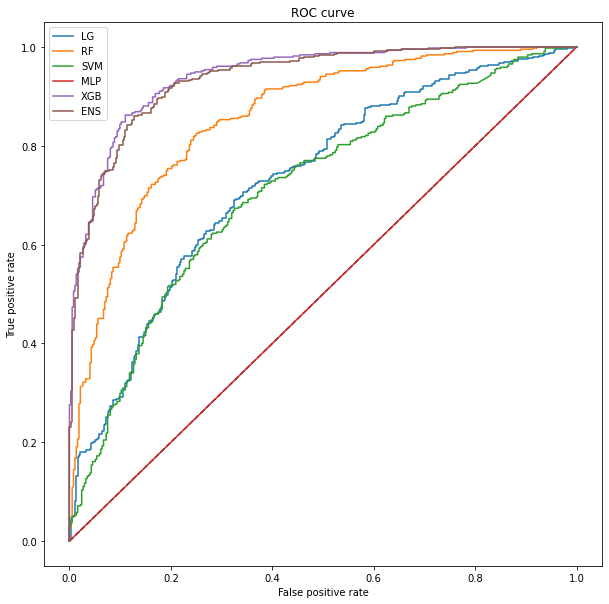

In [10]:


fpr_log, tpr_log, thresholds_log = metrics.roc_curve(ytrain, LG.predict_proba(xtrain[features])[:,1], drop_intermediate=True)
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(ytrain, RF.predict_proba(xtrain[features])[:,1], drop_intermediate=True)
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(ytrain, SVM.predict_proba(xtrain[features])[:,1], drop_intermediate=True)
fpr_dt, tpr_dt, thresholds_dt = metrics.roc_curve(ytrain, DT.predict_proba(xtrain[features])[:,1], drop_intermediate=True)
fpr_mlp, tpr_mlp, thresholds_mlp = metrics.roc_curve(ytrain, MLP.predict_proba(xtrain[features])[:,1], drop_intermediate=True)
fpr_xgb, tpr_xgb, thresholds_xgb = metrics.roc_curve(ytrain, XGB.predict_proba(xtrain[features])[:,1], drop_intermediate=True)
fpr_ens, tpr_ens, thresholds_ens = metrics.roc_curve(ytrain, XGB.predict_proba(xtrain[features])[:,1]*.8+RF.predict_proba(xtrain[features])[:,1]*.2, drop_intermediate=True)

plt.figure(figsize=(10,10))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr_log, tpr_log, label = 'LG')
plt.plot(fpr_rf, tpr_rf, label = 'RF')
plt.plot(fpr_svm, tpr_svm, label = 'SVM')
#plt.plot(fpr_dt, tpr_dt, label = 'DT')
plt.plot(fpr_mlp, tpr_mlp, label = 'MLP')
plt.plot(fpr_xgb, tpr_xgb, label = 'XGB')
plt.plot(fpr_ens, tpr_ens, label = 'ENS')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve')
plt.show()

### XGBoost is our best performing model, plot some information about the model including shap values and feature importances

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


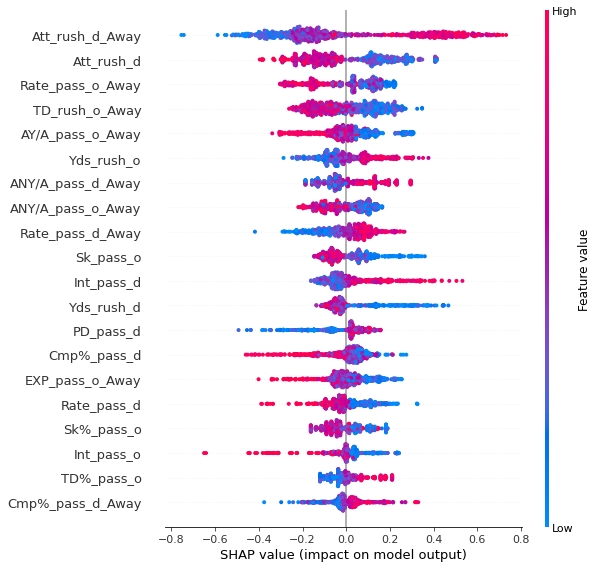

In [11]:
shapvalues = shap.TreeExplainer(XGB).shap_values(xtrain[features])


shap.summary_plot(shapvalues, xtrain[features])

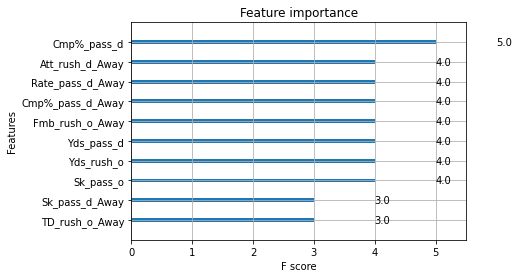

In [12]:
plot_importance(XGB, max_num_features=10)
plt.show()

In [13]:
importances_dict = {}

for i in range(0,len(features)):
    importances_dict[i] = {'feature':features[i], 'importance':(XGB.feature_importances_)[i]}

pd.DataFrame.from_dict(importances_dict).T.sort_values(by='importance', ascending=False).reset_index(drop=True).to_csv('output/football_model_importances.csv')

### Discussion

What I take away from these plots is that good teams rush the ball more. Likely this is because these teams are looking to run out the clock. A team that rushes well doesn't automatically mean that team will win, but teams that are playing ahead more often will have more rushing yards and attempts. Some passing metrics are important in determining who wins the game as well which can be expected. It's important that your offense has a high passer rating and your defense has a low passer rating against them.

### Calculate and Plot Precision at Different Thresholds

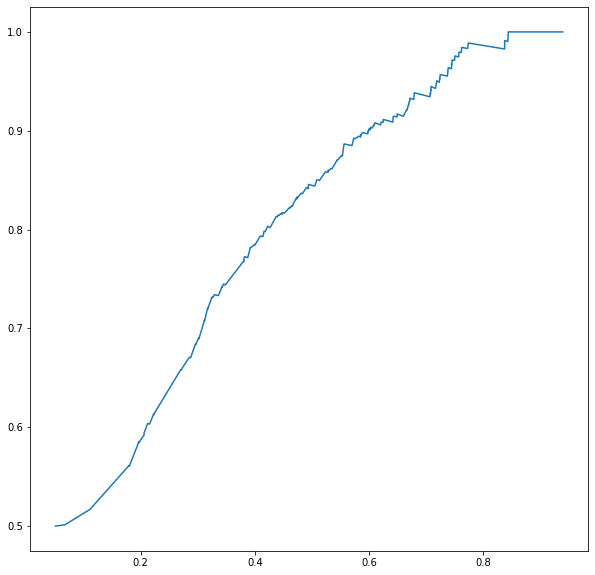

In [14]:
my_dict = {
    'fpr':fpr_xgb,
    'tpr':tpr_xgb,
    'threshold':thresholds_xgb

}

thresholds = pd.DataFrame.from_dict(my_dict)
thresholds['Precision'] = thresholds['tpr']/(thresholds['tpr']+thresholds['fpr'])

plt.figure(figsize=(10,10))
plt.plot(thresholds['threshold'], thresholds['Precision'], label = 'Precision')
plt.show()

### Choose a Threshold then Move on to Validation

In [15]:
thresh = thresholds[(thresholds['tpr']>.8)&(thresholds['fpr']<.15)].reset_index(drop=True).iloc[0,2]
thresh

0.6027774

## Run Some Validation Work on Unseen Data

In [16]:
xtest.insert(5, 'Win', ytest)
xtest.insert(5, 'proba', XGB.predict_proba(xtest[features])[:,1])
xtest.insert(5, 'pred', xtest['proba']>.578)

xtest

,Year,Week,Home,Away,Score_Home,pred,proba,Win,Score_Away,G_pass_o,...,Sk%_pass_d_Away,EXP_pass_d_Away,G_rush_d_Away,Att_rush_d_Away,Yds_rush_d_Away,TD_rush_d_Away,Y/A_rush_d_Away,Y/G_rush_d_Away,EXP_rush_d_Away,Rand_Int
0,2017,5,Texans,Chiefs,34,False,0.514759,False,42,16,...,5.2,-27.52,16,443,1890,15,4.3,118.1,56.69,9
1,2017,11,Giants,Chiefs,12,False,0.377144,True,9,16,...,5.2,-27.52,16,443,1890,15,4.3,118.1,56.69,9
2,2017,13,Jets,Chiefs,38,False,0.385319,True,31,16,...,5.2,-27.52,16,443,1890,15,4.3,118.1,56.69,8
3,2017,10,Rams,Texans,33,True,0.924101,True,7,16,...,6.0,-45.75,16,440,1747,14,4.0,109.2,94.34,8
4,2017,5,Lions,Panthers,24,False,0.503520,False,27,16,...,8.3,7.70,16,353,1409,7,4.0,88.1,90.65,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,2020,9,49ers,Packers,17,False,0.138486,False,34,16,...,7.1,-73.00,16,397,1805,16,4.5,112.8,-36.94,8
213,2020,6,Buccaneers,Packers,38,False,0.494565,True,10,16,...,7.1,-73.00,16,397,1805,16,4.5,112.8,-36.94,9
214,2020,10,Lions,WFT,30,False,0.221798,True,27,16,...,8.2,22.79,16,428,1805,14,4.2,112.8,7.17,8
215,2020,17,Lions,Vikings,35,False,0.119439,False,37,16,...,4.1,-149.87,16,472,2151,19,4.6,134.4,-41.77,9


In [17]:
xtest['proba_bucket'] = np.floor(xtest['proba']*10)
xtest['correct'] = xtest['Win']==xtest['pred']

grp = xtest[['proba_bucket', 'correct']].groupby(['proba_bucket']).mean()
grp = grp.rename(columns={'correct':'correct_pct'})
grp = grp.join(xtest[['proba_bucket', 'correct']].groupby(['proba_bucket']).count())
grp = grp.rename(columns={'correct':'count'})

grp

,correct_pct,count
proba_bucket,,
0.0,1.000000,2
1.0,0.772727,22
2.0,0.636364,33
3.0,0.500000,22
4.0,0.357143,14
5.0,0.640000,25
6.0,0.607143,28
7.0,0.681818,22
8.0,0.833333,42


In [18]:
#Say we were using this for sports gambling purposes, if we only bet when our model estimated win probability above a certain threshold
#How many bets would we win and how many games would we bet on?
average_sum = 0
count = 0
for x in [0,6,7,8,9]:
    average_sum+=grp.iloc[x,0]*grp.iloc[x,1]
    count+=grp.iloc[x,1]

average_sum = average_sum/count
pct = count/len(xtest)

print(f'Average correct for these buckets: {average_sum}')
print(f'Number of games in these buckets: {count}')
print(f'Approx. number of games correct: {average_sum*count}')
print(f'Games in these buckets as a % of all games: {pct}')

Average correct for these buckets: 0.7524752475247525
Number of games in these buckets: 101
Approx. number of games correct: 76.0
Games in these buckets as a % of all games: 0.46543778801843316


In [19]:
grp2 = xtest[['proba_bucket', 'Win']].groupby(['proba_bucket']).sum()
grp2 = grp2.join(xtest[['proba_bucket', 'pred']].groupby(['proba_bucket']).sum())
grp2 = grp2.join(xtest[['proba_bucket', 'Week']].groupby(['proba_bucket']).count())
grp2 = grp2.rename(columns={'Week':'count'})

grp2

,Win,pred,count
proba_bucket,,,
0.0,0,0,2
1.0,5,0,22
2.0,12,0,33
3.0,11,0,22
4.0,9,0,14
5.0,11,4,25
6.0,17,28,28
7.0,15,22,22
8.0,35,42,42


In [20]:
grp2['pct'] = grp2['Win']/grp2['count']

grp2

,Win,pred,count,pct
proba_bucket,,,,
0.0,0,0,2,0.000000
1.0,5,0,22,0.227273
2.0,12,0,33,0.363636
3.0,11,0,22,0.500000
4.0,9,0,14,0.642857
5.0,11,4,25,0.440000
6.0,17,28,28,0.607143
7.0,15,22,22,0.681818
8.0,35,42,42,0.833333


In [21]:
buckets_string =[
    '0-9%',
    '10-19%',
    '20-29%',
    '30-39%',
    '40-49%',
    '50-59%',
    '60-69%',
    '70-79%',
    '80-89%',
    '90-100%'
    ]
grp2.insert(0, 'Probability Bucket', buckets_string)

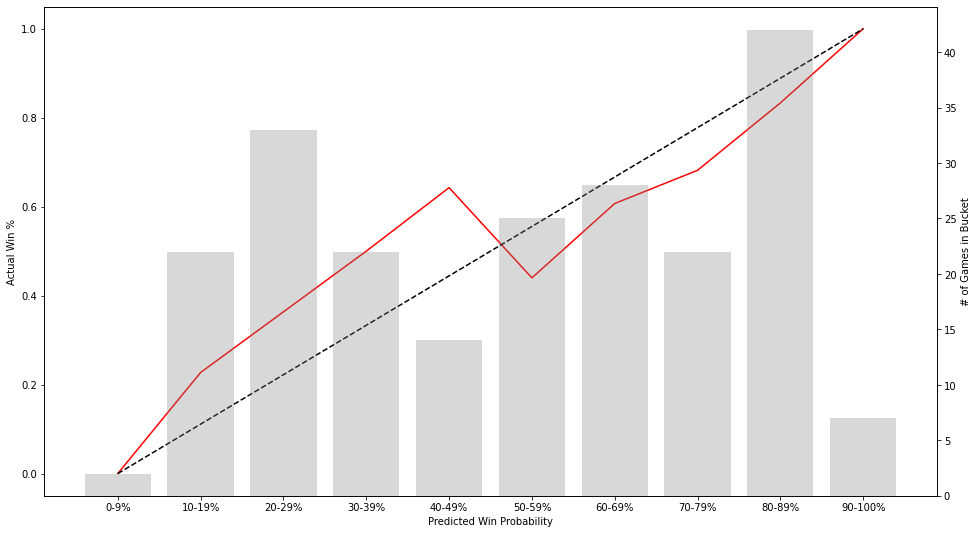

In [22]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax1.plot(grp2['Probability Bucket'], grp2['pct'], label = 'Actual Win %', color='red')
ax2 = ax1.twinx()
ax2.bar(grp2['Probability Bucket'], grp2['count'], label = '# of Games in Bucket', color='gray', alpha=.3)
ax1.plot([0,9], [0,1], 'k--')

ax1.set_xlabel('Predicted Win Probability')
ax1.set_ylabel('Actual Win %')
ax2.set_ylabel('# of Games in Bucket')
plt.show()

## Here I Fit the Model on the Full Set and Do Some Validation Work, I Don't Think This is Valid?

In [23]:
for x in models:
    x.fit(full[features], full['Win'])

Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
Stochastic Optimizer: Maximum iteration

[01:43:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


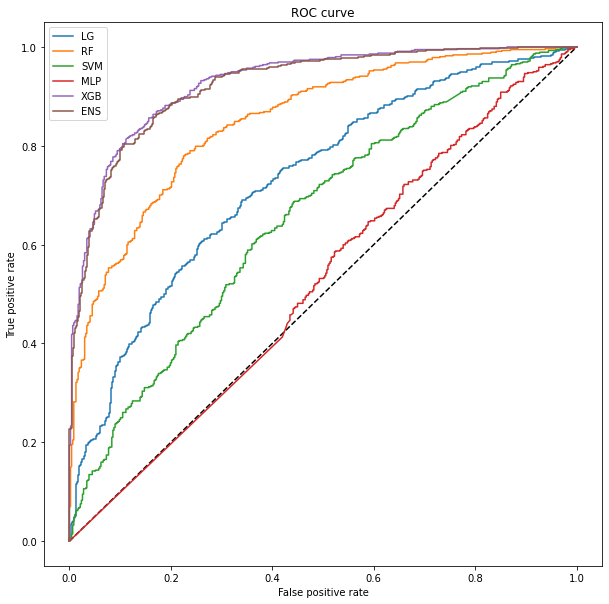

In [24]:
fpr_log, tpr_log, thresholds_log = metrics.roc_curve(full['Win'], LG.predict_proba(full[features])[:,1], drop_intermediate=True)
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(full['Win'], RF.predict_proba(full[features])[:,1], drop_intermediate=True)
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(full['Win'], SVM.predict_proba(full[features])[:,1], drop_intermediate=True)
fpr_dt, tpr_dt, thresholds_dt = metrics.roc_curve(full['Win'], DT.predict_proba(full[features])[:,1], drop_intermediate=True)
fpr_mlp, tpr_mlp, thresholds_mlp = metrics.roc_curve(full['Win'], MLP.predict_proba(full[features])[:,1], drop_intermediate=True)
fpr_xgb, tpr_xgb, thresholds_xgb = metrics.roc_curve(full['Win'], XGB.predict_proba(full[features])[:,1], drop_intermediate=True)
fpr_ens, tpr_ens, thresholds_ens = metrics.roc_curve(full['Win'], XGB.predict_proba(full[features])[:,1]*.8+RF.predict_proba(full[features])[:,1]*.2, drop_intermediate=True)

plt.figure(figsize=(10,10))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr_log, tpr_log, label = 'LG')
plt.plot(fpr_rf, tpr_rf, label = 'RF')
plt.plot(fpr_svm, tpr_svm, label = 'SVM')
#plt.plot(fpr_dt, tpr_dt, label = 'DT')
plt.plot(fpr_mlp, tpr_mlp, label = 'MLP')
plt.plot(fpr_xgb, tpr_xgb, label = 'XGB')
plt.plot(fpr_ens, tpr_ens, label = 'ENS')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve')
plt.show()

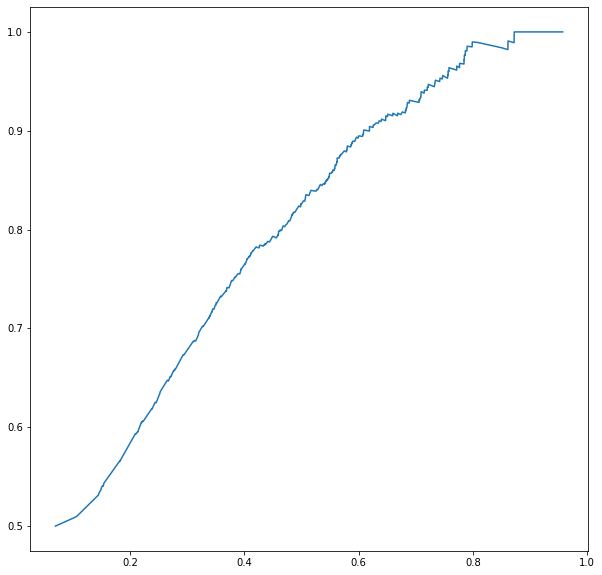

In [25]:
my_dict = {
    'fpr':fpr_xgb,
    'tpr':tpr_xgb,
    'threshold':thresholds_xgb

}

thresholds = pd.DataFrame.from_dict(my_dict)
thresholds['Precision'] = thresholds['tpr']/(thresholds['tpr']+thresholds['fpr'])

plt.figure(figsize=(10,10))
plt.plot(thresholds['threshold'], thresholds['Precision'], label = 'Precision')
plt.show()

In [26]:
thresh = thresholds[(thresholds['tpr']>.8)&(thresholds['fpr']<.15)].reset_index(drop=True).iloc[0,2]
thresh

0.5812556

In [27]:
full.insert(5, 'proba', XGB.predict_proba(full[features])[:,1])
full.insert(5, 'pred', full['proba']>thresh)

full

,Year,Week,Home,Away,Score_Home,pred,proba,Score_Away,Win,G_pass_o,...,Sk%_pass_d_Away,EXP_pass_d_Away,G_rush_d_Away,Att_rush_d_Away,Yds_rush_d_Away,TD_rush_d_Away,Y/A_rush_d_Away,Y/G_rush_d_Away,EXP_rush_d_Away,Rand_Int
0,2017,1,Patriots,Chiefs,27,False,0.569550,42,False,16,...,5.2,-27.52,16,443,1890,15,4.3,118.1,56.69,6
1,2017,5,Texans,Chiefs,34,False,0.291885,42,False,16,...,5.2,-27.52,16,443,1890,15,4.3,118.1,56.69,9
2,2017,9,Cowboys,Chiefs,28,True,0.608932,17,True,16,...,5.2,-27.52,16,443,1890,15,4.3,118.1,56.69,7
3,2017,17,Broncos,Chiefs,24,False,0.316336,27,False,16,...,5.2,-27.52,16,443,1890,15,4.3,118.1,56.69,4
4,2017,3,Chargers,Chiefs,10,False,0.278502,24,False,16,...,5.2,-27.52,16,443,1890,15,4.3,118.1,56.69,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,2020,10,Bears,Vikings,13,False,0.354014,19,False,16,...,4.1,-149.87,16,472,2151,19,4.6,134.4,-41.77,4
1020,2020,14,Buccaneers,Vikings,26,True,0.789952,14,True,16,...,4.1,-149.87,16,472,2151,19,4.6,134.4,-41.77,7
1021,2020,8,Packers,Vikings,22,True,0.667967,28,False,16,...,4.1,-149.87,16,472,2151,19,4.6,134.4,-41.77,3
1022,2020,4,Texans,Vikings,23,False,0.139707,31,False,16,...,4.1,-149.87,16,472,2151,19,4.6,134.4,-41.77,3


In [28]:
full['proba_bucket'] = np.floor(full['proba']*10)
full['correct'] = full['Win']==full['pred']

grp = full[['proba_bucket', 'correct']].groupby(['proba_bucket']).mean()
grp = grp.rename(columns={'correct':'correct_pct'})
grp = grp.join(full[['proba_bucket', 'correct']].groupby(['proba_bucket']).count())
grp = grp.rename(columns={'correct':'count'})

grp

,correct_pct,count
proba_bucket,,
0.0,1.000000,15
1.0,0.976744,129
2.0,0.901639,122
3.0,0.826531,98
4.0,0.561798,89
5.0,0.494624,93
6.0,0.782609,92
7.0,0.864516,155
8.0,0.987730,163


In [29]:
average_sum = 0
count = 0
for x in [0,1,2,7,8,9]:
    average_sum+=grp.iloc[x,0]*grp.iloc[x,1]
    count+=grp.iloc[x,1]

average_sum = average_sum/count
pct = count/len(full)

print(f'Average correct for these buckets: {average_sum}')
print(f'Number of games in these buckets: {count}')
print(f'Approx. number of games correct: {average_sum*count}')
print(f'Games in these buckets as a % of all games: {pct}')

Average correct for these buckets: 0.941717791411043
Number of games in these buckets: 652
Approx. number of games correct: 614.0
Games in these buckets as a % of all games: 0.63671875


In [30]:
grp2 = full[['proba_bucket', 'Win']].groupby(['proba_bucket']).sum()
grp2 = grp2.join(full[['proba_bucket', 'pred']].groupby(['proba_bucket']).sum())
grp2 = grp2.join(full[['proba_bucket', 'Week']].groupby(['proba_bucket']).count())
grp2 = grp2.rename(columns={'Week':'count'})

grp2

,Win,pred,count
proba_bucket,,,
0.0,0,0,15
1.0,3,0,129
2.0,12,0,122
3.0,17,0,98
4.0,39,0,89
5.0,51,16,93
6.0,72,92,92
7.0,134,155,155
8.0,161,163,163


In [31]:
grp2['pct'] = grp2['Win']/grp2['count']

grp2

,Win,pred,count,pct
proba_bucket,,,,
0.0,0,0,15,0.000000
1.0,3,0,129,0.023256
2.0,12,0,122,0.098361
3.0,17,0,98,0.173469
4.0,39,0,89,0.438202
5.0,51,16,93,0.548387
6.0,72,92,92,0.782609
7.0,134,155,155,0.864516
8.0,161,163,163,0.987730


In [32]:
buckets_string =[
    '0-9%',
    '10-19%',
    '20-29%',
    '30-39%',
    '40-49%',
    '50-59%',
    '60-69%',
    '70-79%',
    '80-89%',
    '90-100%'
    ]
grp2.insert(0, 'Probability Bucket', buckets_string)

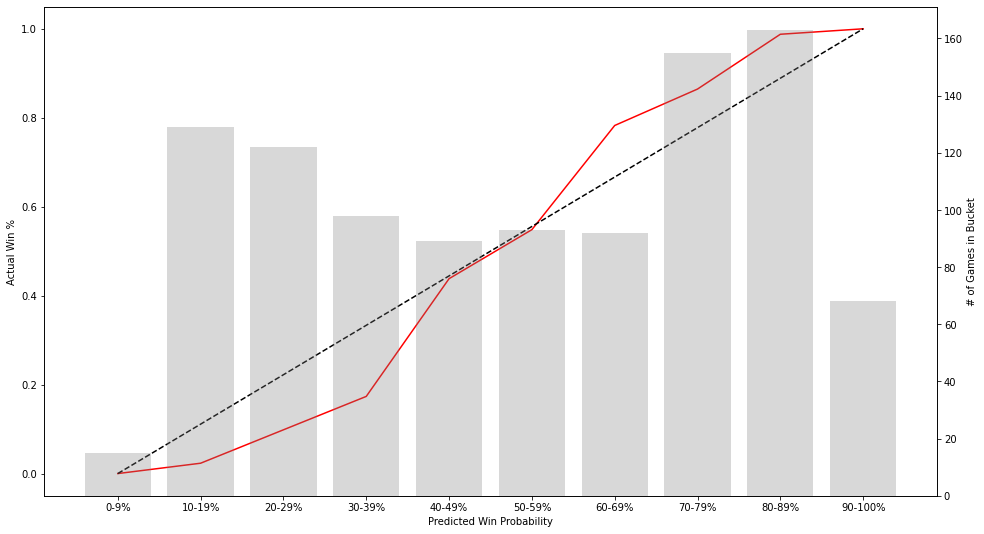

In [33]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax1.plot(grp2['Probability Bucket'], grp2['pct'], label = 'Actual Win %', color='red')
ax2 = ax1.twinx()
ax2.bar(grp2['Probability Bucket'], grp2['count'], label = '# of Games in Bucket', color='gray', alpha=.3)
ax1.plot([0,9], [0,1], 'k--')

ax1.set_xlabel('Predicted Win Probability')
ax1.set_ylabel('Actual Win %')
ax2.set_ylabel('# of Games in Bucket')
plt.show()

## Fit on 2021 Game Results

In [34]:
scores_21 = pd.read_csv('data/nfl_scores_21.csv')

scores_21['Home'] = scores_21['Home'].str.split().str[-1]
scores_21['Home'] = scores_21['Home'].str.replace('Team', 'WFT').replace('Redskins', 'WFT')

scores_21['Away'] = scores_21['Away'].str.split().str[-1]
scores_21['Away'] = scores_21['Away'].str.replace('Team', 'WFT').replace('Redskins', 'WFT')


pass_o_21 = pd.read_csv('data/passing_21.csv')
rushing_o_21 = pd.read_csv('data/rushing_21.csv')

pass_d_21 = pd.read_csv('data/passing_d_21.csv')
rushing_d_21=pd.read_csv('data/rushing_d_21.csv')

In [35]:
pass_o_21['scale'] = 16/pass_o_21['G']

for column in list(set(pass_o_21.columns)-set(['Year','G', 'Tm','Cmp%', 'TD%', 'Int%', 'Lng', 'Y/A', 'AY/A', 'Y/C', 'Y/G', 'Rate','Sk%','EXP','scale'])):
    pass_o_21[column]=pass_o_21[column].astype('float')*pass_o_21['scale']

pass_o_21['TD%']=pass_o_21['TD']/pass_o_21['Att']
pass_o_21['Int%']=pass_o_21['Int']/pass_o_21['Att']
pass_o_21['Sk%']=pass_o_21['Sk']/pass_o_21['Att']

pass_o_21 = rename_cols(pass_o_21, '_pass_o')

In [36]:
rushing_o_21['scale'] = 16/rushing_o_21['G']

for column in list(set(rushing_o_21.columns)-set(['Year', 'G', 'Tm', 'Lng', 'Y/A', 'Y/G','EXP', 'scale'])):
    rushing_o_21[column]=rushing_o_21[column].astype('float')*rushing_o_21['scale']

rushing_o_21 = rename_cols(rushing_o_21, '_rush_o')

In [37]:
pass_d_21['scale'] = 16/pass_d_21['G']

for column in list(set(pass_d_21.columns)-set(['Year','G', 'Tm','Cmp%', 'TD%', 'Int%', 'Y/A','NY/A','ANY/A', 'AY/A', 'Y/C', 'Y/G', 'Rate','Sk%','EXP','scale'])):
    pass_d_21[column]=pass_d_21[column].astype('float')*pass_d_21['scale']

pass_d_21['TD%']=pass_d_21['TD']/pass_d_21['Att']
pass_d_21['Int%']=pass_d_21['Int']/pass_d_21['Att']
pass_d_21['Sk%']=pass_d_21['Sk']/pass_d_21['Att']

pass_d_21 = rename_cols(pass_d_21, '_pass_d')

In [38]:
rushing_d_21['scale'] = 16/rushing_d_21['G']

for column in list(set(rushing_d_21.columns)-set(['Year','G', 'Tm', 'Y/A', 'Y/G','EXP','scale'])):
    rushing_d_21[column]=rushing_d_21[column].astype('float')*rushing_d_21['scale']

rushing_d_21 = rename_cols(rushing_d_21, '_rush_d')

In [39]:
offense_21 = pass_o_21.merge(rushing_o_21, on=['Year', 'Tm'])

defense_21 = pass_d_21.merge(rushing_d_21, on=['Year', 'Tm'])

In [40]:
scores_21 = scores_21.merge(offense_21, left_on=['Year', 'Home'], right_on=['Year', 'Tm'])
scores_21 = scores_21.drop(columns='Tm')
scores_21 = scores_21.merge(defense_21, left_on=['Year', 'Home'], right_on=['Year', 'Tm'])
scores_21 = scores_21.drop(columns='Tm')

scores_21 = scores_21.merge(offense_21, left_on=['Year', 'Away'], right_on=['Year', 'Tm'], suffixes=('', '_Away'))
scores_21 = scores_21.drop(columns='Tm')
scores_21 = scores_21.merge(defense_21, left_on=['Year', 'Away'], right_on=['Year', 'Tm'], suffixes=('', '_Away'))
scores_21 = scores_21.drop(columns='Tm')

In [41]:
scores_21

,Year,Week,Home,Away,Win,Home_Score,Away_Score,G_pass_o,Cmp_pass_o,Att_pass_o,...,EXP_pass_d_Away,scale_pass_d_Away,G_rush_d_Away,Att_rush_d_Away,Yds_rush_d_Away,TD_rush_d_Away,Y/A_rush_d_Away,Y/G_rush_d_Away,EXP_rush_d_Away,scale_rush_d_Away
0,2021,1,Buccaneers,Cowboys,1.0,31.0,29.0,8,472.000000,700.000000,...,-11.53,2.285714,7,331.428571,1412.571429,11.428571,4.3,88.3,-2.44,2.285714
1,2021,14,WFT,Cowboys,NaN,NaN,NaN,8,356.000000,560.000000,...,-11.53,2.285714,7,331.428571,1412.571429,11.428571,4.3,88.3,-2.44,2.285714
2,2021,11,Chiefs,Cowboys,NaN,NaN,NaN,8,454.000000,682.000000,...,-11.53,2.285714,7,331.428571,1412.571429,11.428571,4.3,88.3,-2.44,2.285714
3,2021,13,Saints,Cowboys,NaN,NaN,NaN,7,260.571429,443.428571,...,-11.53,2.285714,7,331.428571,1412.571429,11.428571,4.3,88.3,-2.44,2.285714
4,2021,6,Patriots,Cowboys,0.0,29.0,35.0,8,396.000000,578.000000,...,-11.53,2.285714,7,331.428571,1412.571429,11.428571,4.3,88.3,-2.44,2.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,2021,5,Steelers,Broncos,1.0,27.0,19.0,7,400.000000,617.142857,...,-26.78,2.000000,8,388.000000,1614.000000,12.000000,4.2,100.9,0.43,2.000000
268,2021,2,Jaguars,Broncos,0.0,13.0,23.0,7,368.000000,617.142857,...,-26.78,2.000000,8,388.000000,1614.000000,12.000000,4.2,100.9,0.43,2.000000
269,2021,7,Browns,Broncos,1.0,17.0,14.0,8,316.000000,480.000000,...,-26.78,2.000000,8,388.000000,1614.000000,12.000000,4.2,100.9,0.43,2.000000
270,2021,17,Chargers,Broncos,NaN,NaN,NaN,7,409.142857,644.571429,...,-26.78,2.000000,8,388.000000,1614.000000,12.000000,4.2,100.9,0.43,2.000000


In [42]:
scores_data = scores_21[scores_21['Win'].notna()].reset_index(drop=True)

scores_future = scores_21[scores_21['Win'].isna()].reset_index(drop=True)

scores_future.head()

,Year,Week,Home,Away,Win,Home_Score,Away_Score,G_pass_o,Cmp_pass_o,Att_pass_o,...,EXP_pass_d_Away,scale_pass_d_Away,G_rush_d_Away,Att_rush_d_Away,Yds_rush_d_Away,TD_rush_d_Away,Y/A_rush_d_Away,Y/G_rush_d_Away,EXP_rush_d_Away,scale_rush_d_Away
0,2021,14,WFT,Cowboys,NaN,NaN,NaN,8,356.000000,560.000000,...,-11.53,2.285714,7,331.428571,1412.571429,11.428571,4.3,88.3,-2.44,2.285714
1,2021,11,Chiefs,Cowboys,NaN,NaN,NaN,8,454.000000,682.000000,...,-11.53,2.285714,7,331.428571,1412.571429,11.428571,4.3,88.3,-2.44,2.285714
2,2021,13,Saints,Cowboys,NaN,NaN,NaN,7,260.571429,443.428571,...,-11.53,2.285714,7,331.428571,1412.571429,11.428571,4.3,88.3,-2.44,2.285714
3,2021,15,Giants,Cowboys,NaN,NaN,NaN,8,386.000000,602.000000,...,-11.53,2.285714,7,331.428571,1412.571429,11.428571,4.3,88.3,-2.44,2.285714
4,2021,18,Eagles,Cowboys,NaN,NaN,NaN,8,318.000000,518.000000,...,-11.53,2.285714,7,331.428571,1412.571429,11.428571,4.3,88.3,-2.44,2.285714


In [43]:
scores_data.insert(4, 'proba', XGB.predict_proba(scores_data[features])[:,1])
scores_data.insert(4, 'pred', scores_data['proba']>thresh)

scores_data

,Year,Week,Home,Away,pred,proba,Win,Home_Score,Away_Score,G_pass_o,...,EXP_pass_d_Away,scale_pass_d_Away,G_rush_d_Away,Att_rush_d_Away,Yds_rush_d_Away,TD_rush_d_Away,Y/A_rush_d_Away,Y/G_rush_d_Away,EXP_rush_d_Away,scale_rush_d_Away
0,2021,1,Buccaneers,Cowboys,True,0.642151,1.0,31.0,29.0,8,...,-11.53,2.285714,7,331.428571,1412.571429,11.428571,4.3,88.3,-2.44,2.285714
1,2021,6,Patriots,Cowboys,False,0.350209,0.0,29.0,35.0,8,...,-11.53,2.285714,7,331.428571,1412.571429,11.428571,4.3,88.3,-2.44,2.285714
2,2021,2,Chargers,Cowboys,False,0.262984,0.0,17.0,20.0,7,...,-11.53,2.285714,7,331.428571,1412.571429,11.428571,4.3,88.3,-2.44,2.285714
3,2021,8,Vikings,Cowboys,False,0.399468,0.0,16.0,20.0,7,...,-11.53,2.285714,7,331.428571,1412.571429,11.428571,4.3,88.3,-2.44,2.285714
4,2021,2,Buccaneers,Falcons,True,0.910793,1.0,48.0,25.0,8,...,-44.29,2.285714,7,459.428571,2002.285714,13.714286,4.4,125.1,-19.76,2.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,2021,6,Broncos,Raiders,True,0.613277,0.0,24.0,34.0,8,...,-40.07,2.285714,7,459.428571,2100.571429,18.285714,4.6,131.3,4.88,2.285714
119,2021,1,Giants,Broncos,False,0.186058,0.0,13.0,27.0,8,...,-26.78,2.000000,8,388.000000,1614.000000,12.000000,4.2,100.9,0.43,2.000000
120,2021,5,Steelers,Broncos,False,0.405162,1.0,27.0,19.0,7,...,-26.78,2.000000,8,388.000000,1614.000000,12.000000,4.2,100.9,0.43,2.000000
121,2021,2,Jaguars,Broncos,False,0.508331,0.0,13.0,23.0,7,...,-26.78,2.000000,8,388.000000,1614.000000,12.000000,4.2,100.9,0.43,2.000000


In [44]:
scores_data['proba_bucket'] = np.floor(scores_data['proba']*10)
scores_data['correct'] = scores_data['Win']==scores_data['pred']

grp = scores_data[['proba_bucket', 'correct']].groupby(['proba_bucket']).mean()
grp = grp.rename(columns={'correct':'correct_pct'})
grp = grp.join(scores_data[['proba_bucket', 'correct']].groupby(['proba_bucket']).count())
grp = grp.rename(columns={'correct':'count'})

grp

,correct_pct,count
proba_bucket,,
1.0,0.714286,7
2.0,0.846154,13
3.0,0.800000,15
4.0,0.681818,22
5.0,0.500000,12
6.0,0.500000,20
7.0,0.789474,19
8.0,1.000000,12
9.0,1.000000,3


In [55]:
average_sum = 0
count = 0
for x in [0,1,2,6,7,8]:
    average_sum+=grp.iloc[x,0]*grp.iloc[x,1]
    count+=grp.iloc[x,1]

average_sum = average_sum/count
pct = count/len(scores_data)

print(f'Average correct for these buckets: {average_sum}')
print(f'Number of games in these buckets: {count}')
print(f'Approx. number of games correct: {average_sum*count}')
print(f'Games in these buckets as a % of all games: {pct}')

Average correct for these buckets: 0.8405797101449275
Number of games in these buckets: 69
Approx. number of games correct: 58.0
Games in these buckets as a % of all games: 0.5609756097560976


In [46]:
grp2 = scores_data[['proba_bucket', 'Win']].groupby(['proba_bucket']).sum()
grp2 = grp2.join(scores_data[['proba_bucket', 'pred']].groupby(['proba_bucket']).sum())
grp2 = grp2.join(scores_data[['proba_bucket', 'Week']].groupby(['proba_bucket']).count())
grp2 = grp2.rename(columns={'Week':'count'})

grp2

,Win,pred,count
proba_bucket,,,
1.0,2.0,0,7
2.0,2.0,0,13
3.0,3.0,0,15
4.0,7.0,0,22
5.0,6.0,0,12
6.0,10.0,20,20
7.0,15.0,19,19
8.0,12.0,12,12
9.0,3.0,3,3


In [47]:
grp2['pct'] = grp2['Win']/grp2['count']

grp2

,Win,pred,count,pct
proba_bucket,,,,
1.0,2.0,0,7,0.285714
2.0,2.0,0,13,0.153846
3.0,3.0,0,15,0.200000
4.0,7.0,0,22,0.318182
5.0,6.0,0,12,0.500000
6.0,10.0,20,20,0.500000
7.0,15.0,19,19,0.789474
8.0,12.0,12,12,1.000000
9.0,3.0,3,3,1.000000


In [48]:
buckets_string =[
    '10-19%',
    '20-29%',
    '30-39%',
    '40-49%',
    '50-59%',
    '60-69%',
    '70-79%',
    '80-89%',
    '90-100%'
    ]
grp2.insert(0, 'Probability Bucket', buckets_string)

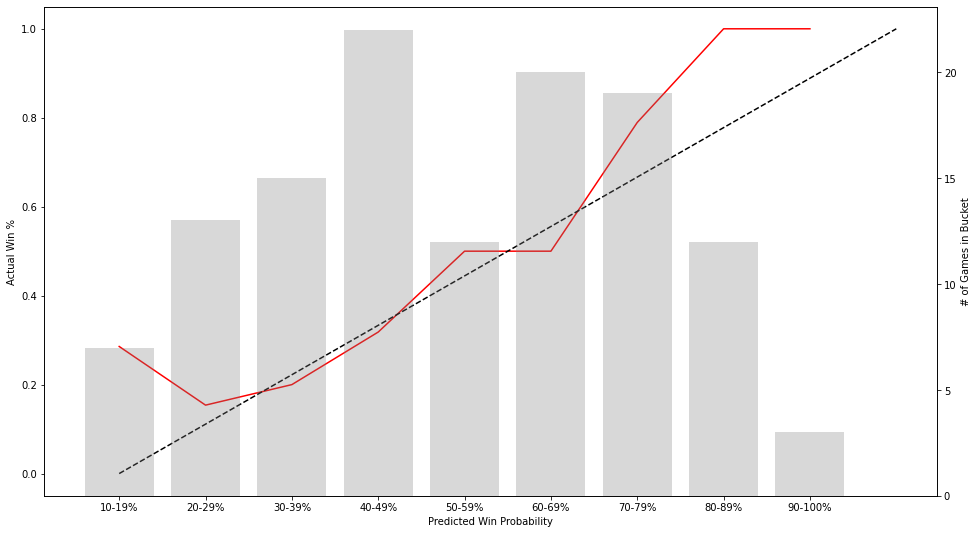

In [49]:
fig, ax1 = plt.subplots(figsize=(16,9))
ax1.plot(grp2['Probability Bucket'], grp2['pct'], label = 'Actual Win %', color='red')
ax2 = ax1.twinx()
ax2.bar(grp2['Probability Bucket'], grp2['count'], label = '# of Games in Bucket', color='gray', alpha=.3)
ax1.plot([0,9], [0,1], 'k--')

ax1.set_xlabel('Predicted Win Probability')
ax1.set_ylabel('Actual Win %')
ax2.set_ylabel('# of Games in Bucket')
plt.show()

In [50]:
scores_future.insert(4, 'proba', XGB.predict_proba(scores_future[features])[:,1])
scores_future.insert(4, 'pred', scores_future['proba']>thresh)

scores_data.to_csv('output/21_preds_played_games.csv')
scores_future.to_csv('output/21_preds_future_games.csv')